In [1]:
import torch
import math
import pyro
from pyro.infer import HMC, MCMC, SVI, Trace_ELBO
from pyro.optim import ClippedAdam
from pyro.distributions import LogNormal, Binomial
from torch.distributions import constraints
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scistats
from scipy.special import binom
from collections import defaultdict

In [24]:
from functools import reduce

In [2]:
# -*- coding: utf-8 -*-

import codecs

def get_basic_phoneme(phoneme):
	if phoneme[-1].isdigit():
		return phoneme[:-1]
	return phoneme

def get_phonemes(phonemes_code):
	return tuple([get_basic_phoneme(phoneme_code) for phoneme_code in phonemes_code.split(';')])

def get_pg_pair(pg_pair_code):
	phonemes_code, grapheme = pg_pair_code.split('>')
	return (get_phonemes(phonemes_code), grapheme)

def get_mapping(mapping_code):
	return tuple([get_pg_pair(pg_pair_code) for pg_pair_code in mapping_code.split('|')])

def read_phonix(input_file_name):
	phonix = []
	with codecs.open(input_file_name, encoding = 'utf-8') as input_file:
		for line in input_file:
			line = line.strip()
			if not line: continue
			word, mapping_code = line.split(' ')
			phonix.append((word, get_mapping(mapping_code)))
	return phonix

def pg_pair_to_str(pg_pair):
	phonemes, grapheme = pg_pair
	return '%s>%s' % (';'.join(phonemes), grapheme)

def mapping_to_str(mapping):
	return '|'.join(pg_pair_to_str(pg_pair) for pg_pair in mapping)

In [3]:
def read_freq_list(freq_file_name):
    wordfreqs = {}
    with open(freq_file_name) as input_file:
        for line in input_file:
            line = line.strip()
            word, freq = line.split(' ')
            freq = float(freq)
            wordfreqs[word] = freq
    return wordfreqs

In [4]:
phonix = read_phonix('../data/phonix.txt')
phonix_dict = dict(phonix)
wordfreqs = read_freq_list('../data/word-freqs.txt')

In [5]:
def normalize(distr):
    denominator = sum(distr.values())
    return {key: float(value) / denominator for key, value in distr.items()}

In [6]:
def get_pg_freqs(wordfreqs, phonix):
    aggregator = defaultdict(float)
    for word, mapping in phonix:
        if word not in wordfreqs: continue
        wordfreq = wordfreqs[word]
        for pg in mapping:
            aggregator[pg_pair_to_str(pg)] += wordfreq
    return normalize(aggregator)

In [7]:
pg_freqs = get_pg_freqs(wordfreqs, phonix)
pgs = sorted(pg_freqs.keys(), key = lambda pg: pg_freqs[pg], reverse=True) # just wanted to sort it to have an intuitive ordering of pg-pairs
ps = np.array([pg_freqs[pg] for pg in pgs])
pg_idx = {pg : i for i, pg in enumerate(pgs)}

In [65]:
observations = [("cat", True), ("dog", True)]

In [9]:
def word_pgs(word):
    return [pg_pair_to_str(pg) for pg in phonix_dict[word]]

In [10]:
def observed_pgs(observations):
    pgs = set()
    for word, obs in observations:
        pgs.update(word_pgs(word))
    return pgs

In [58]:
#prior specifies our prior belief regarding how much pg-pairs the child could have been exposed to
prior_mu = np.log(500) # means that the median pg-pair exposure in our prior belief is 500
prior_sigma = 3 # specifies how spreaded the prior is. For the actual modeling, we want it to be 
                  # quite spreaded. So, the value around 2-3 shall be best. I put it small here to better
                  # show how prior belief can influence our posterior belief.

In [12]:
p_th = 0.01 # probability of our target pg-pair, derived from corpus
n_th_observed = 0 # how much the kid saw this pg-pair

In [13]:
nmax = 10000 # for our simple model, we are going to first do exact posterior calculation. This is very fast
            # with this model, but it will become infeasible with more complex models. We want some reasonable
            # range of possible pg-exposures for this computation. Let's say that it is about 0 and 10000.

In [14]:
# this function computes the discretized lognormal probabilities for a certain range. It uses integral
# over PDF (probability density function) of normal distribution between f(x[i]) and f(x[i+1]), where
# f is the inverse of the transform between normal and lognormal. This integral is
# expressed via CDF (cumulative density function) of the normal distribution
def lognorm_probs(mu, sigma, maxn):
    xs = np.arange(maxn + 1)
    cdfs = np.zeros_like(xs, dtype = float)
    cdfs[xs > 0] = scistats.norm.cdf((np.log(xs[xs > 0]) - mu) / sigma)
    return cdfs[1:] - cdfs[:-1]

In [42]:
# this is a model that replaces the binomial with its continuous approximation (from Central Limit Theorem)
# this seems to actually work
def approximate_model(observations):
    log_n = pyro.sample("log_n_pg_exposed", pyro.distributions.Normal(prior_mu, prior_sigma))
    n = torch.exp(log_n)
    obs_pgs = list(observed_pgs(observations))
    p_pgs = dict()
    for i in pyro.plate('pgs', len(obs_pgs)):
        pg = obs_pgs[i]
        p = ps[pg_idx[pg]]
        n_pg = pyro.sample("n_%s_exposed" % pg, pyro.distributions.Normal(loc = n * p, scale = math.sqrt(n * p * (1 - p))))
        p_pg = max(0, 1 - np.exp(-0.3 * n_pg.item()))
        p_pgs[pg] = p_pg
    for i in pyro.plate('obs', len(observations)):
        word, recall = observations[i]
        the_word_pgs = word_pgs(word)
        p_wrd = reduce(lambda x, y: x * y, map(lambda pg: p_pgs[pg], the_word_pgs))
        pyro.sample("obs_%d" % i, pyro.distributions.Bernoulli(p_wrd), obs = 1.0 if recall else 0.0)

In [43]:
# this is how we would run sampling. Doesn't work! Way too slow!

# pyro.clear_param_store()
# my_kernel = HMC(model)
# my_mcmc = MCMC(my_kernel,
#                num_samples=1000,
#                warmup_steps=100)
# my_mcmc.run(observations)

In [85]:
# This function parametrizes the posterior. Based on considerations described above, I chose the posterior
# number of pg-exposures to come from log-normal. Here, I actually chose to parametrize the log of this value
# (using normal). I think the log parametrization is going to be better, because it naturally accounts for the
# fact that the higher is the mu, the less precision we are going to have.

# I initialize the posterior with the same mu as the prior - it seems to converge quite well
# from that point. But different initializations could be tried.

def guide(observations):
    mu = pyro.param("mu", torch.tensor(prior_mu))
    sigma = pyro.param("sigma", torch.tensor(2), constraint=constraints.positive)
    pyro.sample("log_n_pg_exposed", pyro.distributions.Normal(mu, sigma))
    obs_pgs = list(observed_pgs(observations))
    for i in pyro.plate('pgs', len(obs_pgs)):
        pg = obs_pgs[i]
        pg_mu = pyro.param("mu_%s" % pg, torch.tensor(5))
        pg_sigma = pyro.param("sigma_%s" % pg, torch.tensor(10), constraint=constraints.positive)
        pyro.sample("n_%s_exposed" % pg, pyro.distributions.Normal(loc = pg_mu, scale = pg_sigma))

In [86]:
pyro.clear_param_store()

# Define our SVI algorithm. It accepts our model
# our guide, an optimizer, and a loss function
# to maximize
svi = SVI(model=approximate_model,
             guide=guide,
             optim=ClippedAdam({"lr": 0.001}),
             loss=Trace_ELBO())

# Decide on the number of optimization steps to 
# take, and run the optimizer for that
# many steps.

# We sent the parameters into model and guide
# in the .step() function

losses, mus, sigmas  = [], [], []
for i in range(4000):
    if 0 == i % 100: print(i)
    losses.append(svi.step(observations))
    mus.append(pyro.param("mu").item())
    sigmas.append(pyro.param("sigma").item())

0


RuntimeError: only Tensors of floating point dtype can require gradients
        Trace Shapes:    
         Param Sites:    
                   mu    
                sigma    
        Sample Sites:    
log_n_pg_exposed dist   |
                value   |
             pgs dist   |
                value 6 |

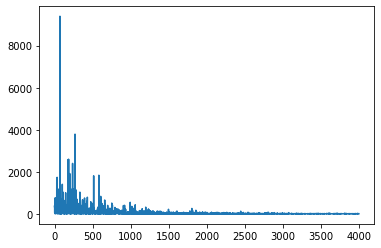

In [76]:
plt.plot(losses)

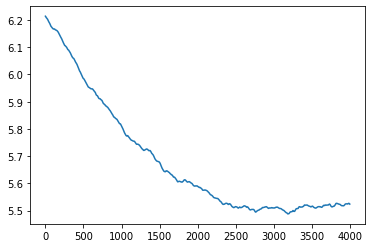

In [77]:
plt.plot(mus)

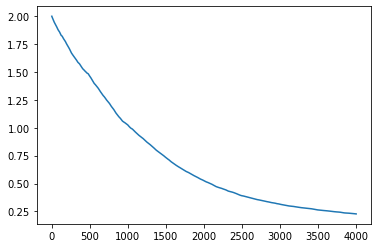

In [78]:
plt.plot(sigmas)

In [79]:
# let's convert our predicted mu and sigma (the last ones in the iteration chain) 
# into the posterior probability distribution!
variational_posterior = lognorm_probs(mus[-1], sigmas[-1], nmax)

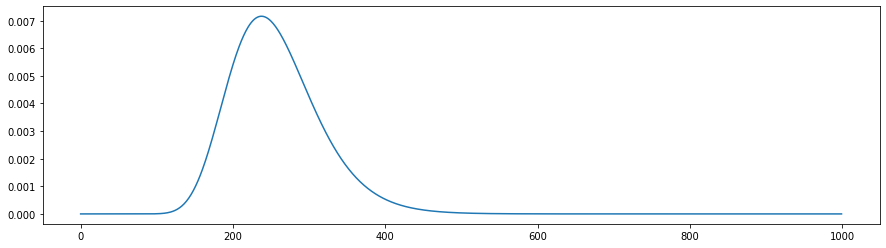

In [80]:
# the match seems to be quite good!
plt.gcf().set_size_inches(15, 4)
plt.plot(variational_posterior[:1000])

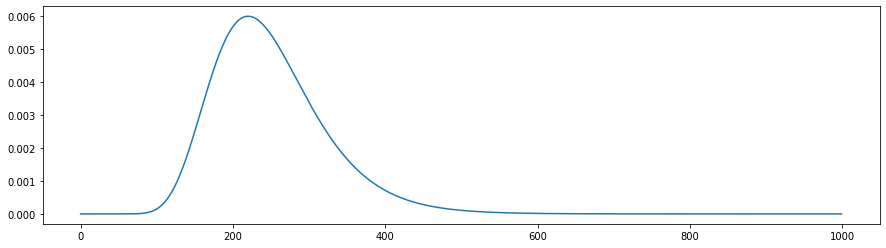

In [73]:
# the match seems to be quite good!
plt.gcf().set_size_inches(15, 4)
plt.plot(variational_posterior[:1000])